In [93]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import vgg
%matplotlib inline
torch.manual_seed(42)
from birkhoff import birkhoff_von_neumann_decomposition as decomp
import ot
import itertools
import networkx as nx
from scipy.sparse import csr_matrix

In [130]:
# CIFAR images are 32x32
# We consider a simple 2x2 jigsaw puzzle.
# 0 1
# 3 2
perm_inds = [(0, 0), (30, 0), (60, 0), (0, 30), (30, 30), (60, 30), (0, 60), (30, 60), (60, 60)]
# Simply maps each pixel to [-1, 1]
img_mean = 0.5
img_std = 0.5
    
def permute2x2(images):
    """
    Splits the images into 3x3=9 pieces and randomly permutes the pieces.
    """
    p_images = torch.FloatTensor(images.size())
    perms = torch.LongTensor(images.size()[0], 9)
    for i in range(images.size()[0]):
        p = torch.randperm(9)
        for j in range(9):
            sr, sc = perm_inds[j]
            tr, tc = perm_inds[p[j]]
            p_images[i, :, tr:tr+30, tc:tc+30] = images[i, :, sr:sr+30, sc:sc+30]
        perms[i,:] = p
    return(p_images, perms)

def restore2x2(p_images, perms):
    """
    Restores the original image from the pieces and the given permutation.
    """
    images = torch.FloatTensor(p_images.size())
    for i in range(images.size()[0]):
        for j in range(9):
            sr, sc = perm_inds[j]
            tr, tc = perm_inds[perms[i, j]]
            images[i, :, sr:sr+30, sc:sc+30] = p_images[i, :, tr:tr+30, tc:tc+30]
    return images

def perm2vecmat2x2(perms):
    """
    Converts permutation vectors to vectorized assignment matrices.
    """
    n = perms.size()[0]
    mat = torch.zeros(n, 9, 9)
    # m[i][j] : i is assigned to j
    for i in range(n):
        for k in range(9):
            mat[i, k, perms[i, k]] = 1.
    return mat.view(n, -1)

def vecmat2perm2x2(x):
    """
    Converts vectorized assignment matrices back to permutation vectors.
    Note: this function is compatible with GPU tensors.
    """    
    x = x.cpu()
    n = x.size()[0]
    x = x.view(n, 9, 9)
    x = x.numpy()
    res = []
    for val in x:
        G = nx.bipartite.from_biadjacency_matrix(csr_matrix(val))
        matches = nx.algorithms.matching.max_weight_matching(G)
        pieces = val.shape[0]
        res_mat = np.zeros((pieces, pieces))
        for i, j in matches:
            if i >= pieces:
                i, j = j, i
            res_mat[i % 9, j % 9] = 1
        res.append(res_mat.argmax(1))

    restorch = torch.from_numpy(np.array(res))
    restorch = restorch.type(torch.LongTensor)
    return restorch

    
def imshow(img, title=None):
    """
    Displays a torch image.
    """
    img = img * img_std + img_mean
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title != None:
        plt.title(title)

Files already downloaded and verified


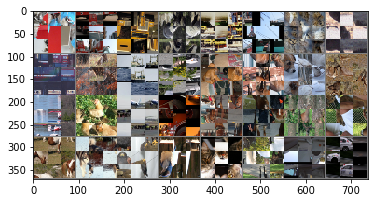

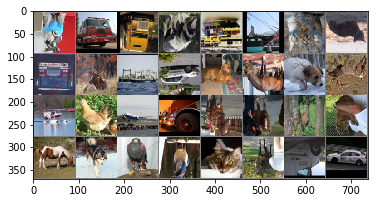

In [131]:
batch_size = 32
dataset_dir = './data'

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.Resize(90),
     transforms.ToTensor(),
     transforms.Normalize((img_mean, img_mean, img_mean), (img_std, img_std, img_std))])

train_set = torchvision.datasets.STL10(root=dataset_dir, split='train', download=True, transform=transform)

# Plot some training samples.
sample_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                            shuffle=True, num_workers=0)
dataiter = iter(sample_loader)
images, labels = next(dataiter)

p_images, perms = permute2x2(images)
# Check the implementation of perm2vecmat and vecmat2perm.
assert(vecmat2perm2x2(perm2vecmat2x2(perms)).equal(perms))

# Show permuted images.
plt.figure()
imshow(torchvision.utils.make_grid(p_images))
# Show restored images.
plt.figure()
imshow(torchvision.utils.make_grid(restore2x2(p_images, perms)))

In [132]:
# Prepare training, validation, and test samples.
validation_ratio = 0.1
total = len(train_set)
ind = list(range(total))
n_train = int(np.floor((1. - validation_ratio) * total))
train_ind, validation_ind = ind[:n_train], ind[n_train:]
train_subsampler = torch.utils.data.sampler.SubsetRandomSampler(train_ind)
validation_subsampler = torch.utils.data.sampler.SubsetRandomSampler(validation_ind)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           sampler=train_subsampler, num_workers=0)
validation_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                sampler=validation_subsampler, num_workers=0)

print('Number of training batches: {}'.format(len(train_loader)))
print('Number of validation batches: {}'.format(len(validation_loader)))

test_set = torchvision.datasets.STL10(root=dataset_dir, split='test', download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

Number of training batches: 141
Number of validation batches: 16
Files already downloaded and verified


In [152]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def sinkhorn(A, n_iter=4):
    """
    Sinkhorn iterations.
    """
    
    for i in range(n_iter):
        A = A.clone()/A.sum(dim=1, keepdim=True)
        A = A.clone()/A.sum(dim=2, keepdim=True)

    return A

def restoreImage(x):
    x = x.numpy()
    res = []
    i = 0
    rows = {}
    cols = {}
    
    for val in x:
        pairs = decomp(val)
        coeff, permmat = zip(*pairs)
        res.append(np.argmax(permmat[np.argmax(coeff)], axis=1))
        
    restorch = torch.from_numpy(np.array(res))
    return restorch

class SimpleConvNet(nn.Module):
    """
    A simple convolutional neural network shared among all pieces.
    """
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # 3 x 16 x 16 input
        self.conv1 = nn.Conv2d(3, 8, 3)
        # 8 x 14 x 14
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.conv2_bn = nn.BatchNorm2d(8)
        # 8 x 12 x 12
        self.pool1 = nn.MaxPool2d(2, 2)
        # 8 x 6 x 6
        self.conv3 = nn.Conv2d(8, 16, 3)
        self.conv3_bn = nn.BatchNorm2d(16)
        # 16 x 4 x 4
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        # 128-d features
        self.fc2 = nn.Linear(128, 128)
        self.fc2_bn = nn.BatchNorm1d(128)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        return x

class JigsawNet(nn.Module):
    """
    A neural network that solves 2x2 jigsaw puzzles.
    """
    def __init__(self, sinkhorn_iter=0):
        super(JigsawNet, self).__init__()
        vggmodel = vgg.__dict__["vgg11_bn"]()
        vggmodel.features = torch.nn.DataParallel(vggmodel.features)
        self.conv_net = vggmodel
        self.fc1 = nn.Linear(9*512, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        # 4 x 4 assigment matrix
        self.fc2 = nn.Linear(256, 81)
        self.sinkhorn_iter = sinkhorn_iter
    
    def forward(self, x):
        # Split the input into four pieces and pass them into the
        # same convolutional neural network.
        x0 = self.conv_net(x[:, :, 0:30, 0:30])
        x1 = self.conv_net(x[:, :, 30:60, 0:30])
        x2 = self.conv_net(x[:, :, 60:90, 0:30])
        x3 = self.conv_net(x[:, :, 0:30, 30:60])
        x4 = self.conv_net(x[:, :, 30:60, 30:60])
        x5 = self.conv_net(x[:, :, 60:90, 30:60])
        x6 = self.conv_net(x[:, :, 0:30, 60:90])
        x7 = self.conv_net(x[:, :, 30:60, 60:90])
        x8 = self.conv_net(x[:, :, 60:90, 60:90])
        # Cat
        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7, x8], dim=1)
        # Dense layer
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.sigmoid(self.fc2(x))
        if self.sinkhorn_iter > 0:
            x = x.view(-1, 9, 9)
            x = sinkhorn(x, self.sinkhorn_iter)
            x = x.view(-1, 81)
        return x

In [153]:
# Test helper
def compute_acc(p_pred, p_true, average=True):
    """
    We require that the location of all four pieces are correctly predicted.
    Note: this function is compatible with GPU tensors.
    """
    # Remember to cast to float.
    n = torch.sum((torch.sum(p_pred == p_true, 1) == 9).float())
    if average:
        return n / p_pred.size()[0]
    else:
        return n

# Training process
def train_model(model, criterion, optimizer, train_loader, validation_loader,
                n_epochs=40, save_file_name=None):
    loss_history = []
    val_loss_history = []
    acc_history = []
    val_acc_history = []
    for epoch in range(n_epochs):
        with tqdm_notebook(total=len(train_loader), desc="Epoch {}".format(epoch + 1), unit='b', leave=False) as pbar:
            # Training phase
            model.train()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(train_loader, 0):
                inputs, _ = data
                x_in, perms = permute2x2(inputs)
                y_in = perm2vecmat2x2(perms)
                n_samples += inputs.size()[0]
                if is_cuda_available:
                    x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
                    perms = Variable(perms.cuda())
                else:
                    x_in, y_in = Variable(x_in), Variable(y_in)
                    perms = Variable(perms)
                optimizer.zero_grad()
                outputs = model(x_in)
                cloneOutput = outputs.data.clone().cpu()
                n_correct_pred += compute_acc(vecmat2perm2x2(cloneOutput), perms.data.cpu(), False)
                loss = criterion(outputs, y_in)
                loss.backward()
                optimizer.step()
                running_loss += loss.data[0] * x_in.size()[0]
                pbar.update(1)
            loss_history.append(running_loss / n_samples)
            acc_history.append(n_correct_pred / n_samples)
            
            # Validation phase
            model.eval()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(validation_loader, 0):
                inputs, _ = data
                x_in, perms = permute2x2(inputs)
                y_in = perm2vecmat2x2(perms)
                n_samples += inputs.size()[0]
                if is_cuda_available:
                    x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
                    perms = Variable(perms.cuda())
                else:
                    x_in, y_in = Variable(x_in), Variable(y_in)
                    perms = Variable(perms)
                outputs = model(x_in)
                cloneOutput = outputs.data.clone().cpu()
                n_correct_pred += compute_acc(vecmat2perm2x2(cloneOutput), perms.data.cpu(), False)
                loss = criterion(outputs, y_in)
                running_loss += loss.data[0] * x_in.size()[0]
            val_loss_history.append(running_loss / n_samples)
            val_acc_history.append(n_correct_pred / n_samples)
            
            # Update the progress bar.
            print("Epoch {0:03d}: loss={1:.4f}, val_loss={2:.4f}, acc={3:.2%}, val_acc={4:.2%}".format(
                epoch + 1, loss_history[-1], val_loss_history[-1], acc_history[-1], val_acc_history[-1]))
    print('Training completed')
    history = {
        'loss': loss_history,
        'val_loss': val_loss_history,
        'acc': acc_history,
        'val_acc': val_acc_history
    }
    # Save the model when requested.
    if save_file_name is not None:
        torch.save({
            'history': history,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, save_file_name)
    return history

# Test process
# Compute the accuracy
def test_model(model, test_loader):
    running_acc = 0.
    n = 0
    model.eval()
    for i, data in enumerate(test_loader, 0):
        inputs, _ = data
        x_in, perms = permute2x2(inputs)
        y_in = perm2vecmat2x2(perms)
        if is_cuda_available:
            x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
        else:
            x_in, y_in = Variable(x_in), Variable(y_in)
        pred = model(x_in)
        perms_pred = vecmat2perm2x2(pred.cpu().data)
        running_acc += compute_acc(perms_pred, perms, False)
        n += x_in.size()[0]
    acc = running_acc / n
    return acc

In [154]:
n_epochs = 10
sinkhorn_iter = 10

# Create the neural network.
model = JigsawNet(sinkhorn_iter=sinkhorn_iter)
is_cuda_available = torch.cuda.is_available();
if is_cuda_available:
    model.cuda()

n_params = 0
for p in model.parameters():
    n_params += np.prod(p.size())
print('# of parameters: {}'.format(n_params))

# We use binary cross-entropy loss here.
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Train
save_file_name = 'jigsaw_cifar100_e{}_s{}.pk'.format(n_epochs, sinkhorn_iter)
history = train_model(model, criterion, optimizer, train_loader, validation_loader,
                      n_epochs=n_epochs, save_file_name=save_file_name)

# of parameters: 3875163


Epoch 001: loss=0.3475, val_loss=0.3430, acc=0.00%, val_acc=0.00%


Epoch 002: loss=0.3395, val_loss=0.3338, acc=0.04%, val_acc=0.00%


Epoch 003: loss=0.3275, val_loss=0.3183, acc=0.09%, val_acc=0.20%


Epoch 004: loss=0.3166, val_loss=0.3070, acc=0.18%, val_acc=0.40%


Epoch 005: loss=0.3100, val_loss=0.3075, acc=0.18%, val_acc=0.20%


KeyboardInterrupt: 

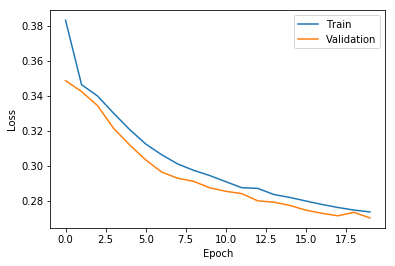

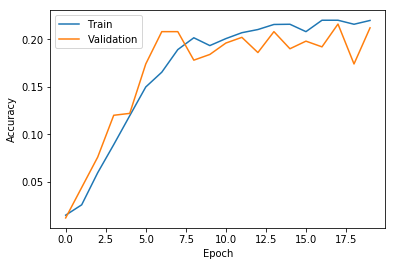

In [31]:
plt.figure()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()
plt.figure()
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [32]:
# Calculate accuracy
print('Training accuracy: {}'.format(test_model(model, train_loader)))
print('Validation accuracy: {}'.format(test_model(model, validation_loader)))
print('Test accuracy: {}'.format(test_model(model, test_loader)))
# Here training accuracy will be higher because dropout is disabled

Training accuracy: 0.209333333333
Validation accuracy: 0.18
Test accuracy: 0.210875


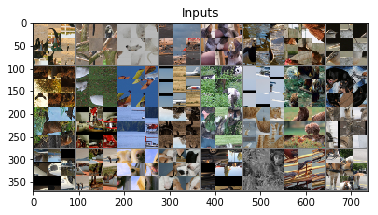

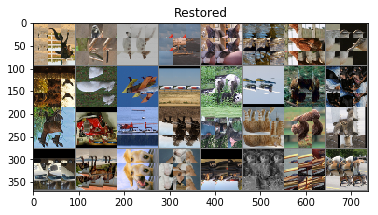

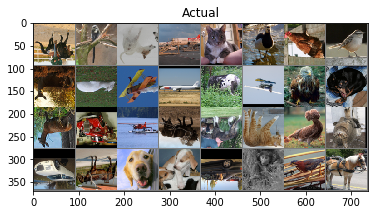

In [33]:
# Let us try some test images.
test_data_iter = iter(test_loader)
test_images, _ = test_data_iter.next()
p_images, perms = permute2x2(test_images)

# Show permuted images.
plt.figure()
imshow(torchvision.utils.make_grid(p_images))
plt.title('Inputs')
plt.show()

model.eval()
if is_cuda_available:
    pred = model(Variable(p_images.cuda()))
else:
    pred = model(Variable(p_images))
perms_pred = vecmat2perm2x2(pred.cpu().data)

# Show restored images.
plt.figure()
imshow(torchvision.utils.make_grid(restore2x2(p_images, perms_pred)))
plt.title('Restored')
plt.show()

plt.figure()
imshow(torchvision.utils.make_grid(test_images))
plt.title('Actual')
plt.show()

In [9]:
model_data = torch.load("jigsaw_cifar100_e20_s10.pk")
model = JigsawNet(sinkhorn_iter=10)
model.load_state_dict(model_data['model'])

In [11]:
history = model_data['history']

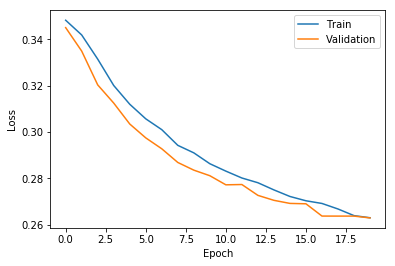

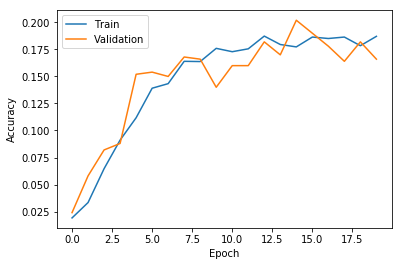

In [12]:
plt.figure()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()
plt.figure()
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [16]:
is_cuda_available = torch.cuda.is_available();
if is_cuda_available:
    model = model.cuda()
# Calculate accuracy
print('Training accuracy: {}'.format(test_model(model, train_loader)))
print('Validation accuracy: {}'.format(test_model(model, validation_loader)))
print('Test accuracy: {}'.format(test_model(model, test_loader)))
# Here training accuracy will be higher because dropout is disabled

Training accuracy: 0.177333333333
Validation accuracy: 0.18
Test accuracy: 0.1735


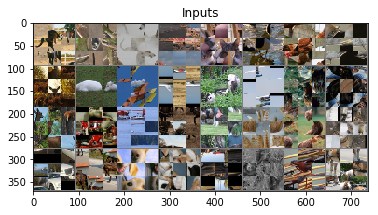

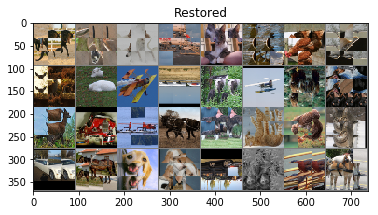

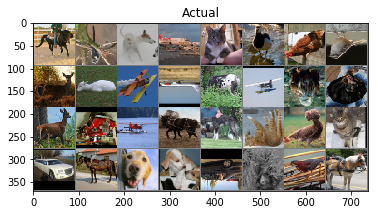

In [17]:
# Let us try some test images.
test_data_iter = iter(test_loader)
test_images, _ = test_data_iter.next()
p_images, perms = permute2x2(test_images)

# Show permuted images.
plt.figure()
imshow(torchvision.utils.make_grid(p_images))
plt.title('Inputs')
plt.show()

model.eval()
if is_cuda_available:
    pred = model(Variable(p_images.cuda()))
else:
    pred = model(Variable(p_images))
perms_pred = vecmat2perm2x2(pred.cpu().data)

# Show restored images.
plt.figure()
imshow(torchvision.utils.make_grid(restore2x2(p_images, perms_pred)))
plt.title('Restored')
plt.show()

plt.figure()
imshow(torchvision.utils.make_grid(test_images))
plt.title('Actual')
plt.show()